In [36]:
import pandas as pd
import numpy as np
import joblib

## ML libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from pygam import LogisticGAM, s

## visalization libraries
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:2f}'.format)

## Data Prep

In [37]:
master_trackman = pd.read_csv('../../Trackman CSV Files/merged_trackman_games.csv')
master_trackman.head()

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/2981408051.py:1: DtypeWarning: Columns (91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  master_trackman = pd.read_csv('../../Trackman CSV Files/merged_trackman_games.csv')


,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-04-08,19:04:21.64,1,1,"Gilbert, Bradley",831228.000000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000000,Left,SEA_RED,Undefined,1,Top,0,0,0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028060,-3.296976,-1.238717,2497.731876,193.680625,12:30,5.621390,0.510940,5.836200,-16.090760,18.231070,4.190400,1.212030,-0.291350,83.110150,-6.326811,-0.487350,0.421654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.463980,10.486150,-0.412500,50.000000,5.342850,2.649920,-130.679410,-8.015750,-4.299720,25.181650,-13.875380,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,18b54860-14e7-11f0-938f-b5417cf72451,89.391770,NaN,NaN,6.917910,NaN,NaN,NaN,NaN,NaN,NaN,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:04:21.64,2025-04-08T19:04:21.6401920-07:00,2025-04-09T02:04:21.6401920Z,NaN,v3,471486.000000,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1000114026.000000,Right,WAS_HUS,69bcc3f1-572b-4f97-8e16-e8d65a83174d,54.662890,-131.574870,12.590830,5.619120,-7.522340,-6.937690,-0.509450,2.802820,-2.149860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2025-04-08,19:04:34.59,1,2,"Gilbert, Bradley",831228.000000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000000,Left,SEA_RED,Undefined,1,Top,0,1,0,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.167840,1.675543,-0.415000,2782.722426,155.127014,11:15,5.533740,0.741550,4.993150,-35.983520,6.645160,-2.487760,4.117590,0.142400,75.363000,-4.887176,-0.853995,0.469918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.118030,3.249250,-0.699510,50.000000,5.665960,0.971940,-119.219350,2.168950

In [38]:
## checking for duplicates in merged files
master_trackman = master_trackman.drop_duplicates(subset = ['PitchUID'])
master_trackman['PlayResult'].unique()

array(['Undefined', 'Out', 'Single', 'Double', 'FieldersChoice', 'Error',
       'Sacrifice', 'Triple', 'HomeRun', 'StolenBase', 'CaughtStealing',
       'SIngle', 'Homerun', 'FIeldersChoice', 'triple'], dtype=object)

In [39]:
necessary_data = master_trackman[['Pitcher', 'PitcherTeam','PitcherThrows', 'Batter', 'BatterTeam', 'BatterSide', 'TaggedPitchType', 'AutoPitchType', 'PitchCall', 'KorBB', 'TaggedHitType', 'PlayResult', 'OutsOnPlay', 'RunsScored', 'RelSpeed', 'SpinRate', 'Tilt', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'ExitSpeed', 'Angle', 'Direction', 'Distance', 'Bearing', 'HangTime', 'PitchUID']]
necessary_data = necessary_data.dropna(subset = ['PitchCall', 'PlayResult'])
necessary_data

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID
0,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028060,2497.731876,12:30,5.621390,0.510940,5.836200,18.231070,4.190400,1.212030,-0.291350,NaN,NaN,NaN,NaN,NaN,NaN,18b54860-14e7-11f0-938f-b5417cf72451
1,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.167840,2782.722426,11:15,5.533740,0.741550,4.993150,6.645160,-2.487760,4.117590,0.142400,NaN,NaN,NaN,NaN,NaN,NaN,205779d0-14e7-11f0-938f-b5417cf72451
2,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,89.170310,2457.952019,12:30,5.673900,0.637670,6.021180,20.687960,4.343740,2.428360,-1.368630,NaN,NaN,NaN,NaN,NaN,NaN,298b6ed0-14e7-11f0-938f-b5417cf72451
3,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.468310,2434.164084,12:30,5.668940,0.529090,5.920580,20.049890,3.916180,3.726920,-0.706240,NaN,NaN,NaN,NaN,NaN,NaN,3189ca00-14e7-11f0-938f-b5417cf72451
4,"Gilbert, Bradley",WAS_HUS,Right,"Peterson, Tyler",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,88.799670,2487.422652,12:45,5.699690,0.707000,5.903890,15.885320,5.797090,3.729990,-1.122990,NaN,NaN,NaN,NaN,NaN,NaN,445b4b40-14e7-11f0-938f-b5417cf72451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326000,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,StrikeCalled,Undefined,Undefined,Undefined,0,0,85.578950,2309.550718,11:00,5.343220,2.092230,6.157400,4.977010,-1.972250,2.480910,-0.516160,NaN,NaN,NaN,NaN,NaN,NaN,5bdd03d0-11d6-11f0-b75a-15defc8841bc
1326001,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,FoulBallNotFieldable,Undefined,Undefined,Undefined,0,0,87.422390,2299.056403,10:45,5.260250,2.269660,6.038550,6.124730,-3.600440,1.818140,0.106260,46.703320,50.600354,120.524254,116.274000,126.704006,3.081668,6451ee90-11d6-11f0-b75a-15defc8841bc
1326002,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,InPlay,Undefined,Popup,Out,1,0,87.589110,2338.856413,10:30,5.275490,2.220830,6.206060,4.687760,-3.380080,2.490030,-0.199540,68.609820,40.223331,-3.564189,197.333360,8.108297,4.536495,6f267430-11d6-11f0-b75a-15defc8841bc
1326003,"Hicks, Garrett",ARI_WIL,Right,"Hairston, Landon",ARI_SUN,Left,Cutter,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,85.486640,2312.444806,10:45,5.265290,2.252450,6.183890,7.524530,-4.503700,1.809560,-1.219740,NaN,NaN,NaN,NaN,NaN,NaN,82a5c1a0-11d6-11f0-b75a-15defc8841bc


In [40]:
## xBA hit encoder

necessary_data = necessary_data[
    (necessary_data['PitchCall'] == 'InPlay') | 
    (necessary_data['KorBB'].isin(['Strikeout']))
]

necessary_data['Hit'] = ((necessary_data['PlayResult'].isin(['Single', 'Double', 'Triple', 'Home Run', 'SIngle', 'Homerun', 'triple', 'HomeRun']))).astype(int)
necessary_data.head()

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/4115540601.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['Hit'] = ((necessary_data['PlayResult'].isin(['Single', 'Double', 'Triple', 'Home Run', 'SIngle', 'Homerun', 'triple', 'HomeRun']))).astype(int)


,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0
28,"Liddle, Brady",SEA_RED,Right,"Guerrero, AJ",WAS_HUS,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0
31,"Liddle, Brady",SEA_RED,Right,"Taggart, Casen",WAS_HUS,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0


In [41]:
## xSLG total base encoder

mapping = {
    'Single': 1, 'SIngle': 1,
    'Double': 2,
    'Triple': 3, 'triple': 3,
    'Home Run': 4, 'Homerun': 4, 'HomeRun': 4
}

necessary_data['Bases'] = necessary_data['PlayResult'].map(mapping).fillna(0).astype(int)
necessary_data.head()


/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/1822225252.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['Bases'] = necessary_data['PlayResult'].map(mapping).fillna(0).astype(int)


,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0,0
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1,1
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0,0
28,"Liddle, Brady",SEA_RED,Right,"Guerrero, AJ",WAS_HUS,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0,0
31,"Liddle, Brady",SEA_RED,Right,"Taggart, Casen",WAS_HUS,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0,0


In [42]:
feature_cols = ['ExitSpeed', 'Angle']
target_col = ['Hit']

In [43]:
necessary_data['PlayResult'].value_counts()

PlayResult
Out               128066
Undefined          67073
Single             53373
Double             15218
HomeRun             9090
Sacrifice           6937
FieldersChoice      6144
Error               5677
Triple              1688
StolenBase            67
CaughtStealing        30
SIngle                 4
Homerun                1
FIeldersChoice         1
triple                 1
Name: count, dtype: int64

In [44]:
necessary_data[feature_cols] = necessary_data[feature_cols].fillna(0)

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/1382998981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data[feature_cols] = necessary_data[feature_cols].fillna(0)


In [45]:
X = necessary_data[feature_cols].values
y = necessary_data[target_col].values

## Logistic GAM (xBA)

In [46]:
from pygam import LogisticGAM, s, LinearGAM
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
import numpy as np

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# define GAM
xba_gam = LogisticGAM(s(0) + s(1), fit_intercept=True, max_iter=100)

# use pygam’s internal k-fold CV to select smoothing
xba_gam.gridsearch(X_train, y_train, progress=False)

# evaluate on test set
y_pred_proba = xba_gam.predict_mu(X_test)  

test_logloss = log_loss(y_test, y_pred_proba)
test_auc = roc_auc_score(y_test, y_pred_proba)
test_brier = brier_score_loss(y_test, y_pred_proba)

print("Test log-loss:", test_logloss)
print("Test AUC:", test_auc)
print("Test Brier score:", test_brier)


Test log-loss: 0.41598633919600353
Test AUC: 0.8489600673207283
Test Brier score: 0.13490288247718715


## Linear GAM (xSLG)

In [47]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## setting target column to be total bases
target_col = ['Bases']
y = necessary_data[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# running model for xSLG
xslg_gam = LinearGAM(s(0) + s(1), fit_intercept=True, max_iter=100)

# use pygam’s internal k-fold CV to select smoothing
xslg_gam.gridsearch(X_train, y_train, progress=False)

# evaluate on test set
y_pred = xslg_gam.predict(X_test)  

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("xSLG Model Performance on Test Set")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}") 

xSLG Model Performance on Test Set
RMSE: 0.725
MAE:  0.438
R²:   0.303


In [48]:
necessary_data['xBA'] = xba_gam.predict_mu(X).round(3)
necessary_data['xSLG'] = xslg_gam.predict(X).round(3)
necessary_data.head()

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/298496436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['xBA'] = xba_gam.predict_mu(X).round(3)
/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/298496436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  necessary_data['xSLG'] = xslg_gam.predict(X).round(3)


,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0,0,0.127000,0.309000
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1,1,0.453000,0.890000
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0,0,0.277000,0.898000
28,"Liddle, Brady",SEA_RED,Right,"Guerrero, AJ",WAS_HUS,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0,0,0.150000,0.596000
31,"Liddle, Brady",SEA_RED,Right,"Taggart, Casen",WAS_HUS,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0,0,0.238000,0.657000


In [49]:
necessary_data.sort_values(by = ['xBA', 'xSLG'], ascending = False).head()

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG
1091046,"Sumner, Garrison",BYU_COU,Right,"Rodriguez, Dominic",ARI_WIL,Right,Slider,Slider,InPlay,Undefined,LineDrive,Out,1,0,83.026040,2352.811215,10:15,5.710840,1.719800,5.648750,2.517800,-1.457760,2.102660,0.520830,110.467340,13.705199,-25.249237,315.711640,-32.252284,2.701378,58451aa0-1d48-11f0-bfd3-2fe6dcbc942e,0,0,0.866000,1.634000
1244056,"Kendrick, Noah",SAM_BEA,Right,"Tryon, Ben",DAL_PAT,Left,Fastball,Sinker,InPlay,Undefined,LineDrive,Double,0,2,87.363740,1964.391180,2:00,5.927750,1.204490,6.266650,10.754890,15.102800,2.176440,0.748740,110.414100,13.723311,12.526637,272.965280,13.445794,2.312395,752e41d0-1be2-11f0-bb8d-1dd291614907,1,2,0.866000,1.634000
578685,"Kirk, Corbin",UTA_WOL,Left,"Brown, Jake",CAL_LAN,Right,Fastball,Four-Seam,InPlay,Undefined,LineDrive,Double,0,0,90.126770,2211.369120,11:15,5.593460,-1.796740,5.519210,12.228670,-5.568740,1.808530,-0.140420,111.324220,13.863687,-34.337720,265.735480,-43.432962,2.340140,25367670-2236-11f0-b0a7-57c124324c7e,1,2,0.866000,1.633000
1079731,"Nove, Jackson",KEN_WIL,Left,"Borba, Casey",TEX_LON,Right,FourSeamFastBall,Four-Seam,InPlay,Undefined,LineDrive,Double,0,0,90.775520,2423.309400,11:00,5.915320,-1.568870,6.154890,15.202530,-8.465560,2.516420,0.039510,110.488730,13.668413,-27.184626,260.741600,-35.243507,2.340053,235171c0-17cd-11f0-95c0-d5575c957047,1,2,0.866000,1.633000
320142,"Selvig, Cole",MIN_GOL,Right,"Walsh, Jacob",ORE_DUC,Left,Cutter,Slider,InPlay,Undefined,LineDrive,Out,1,0,85.654330,2185.679349,1:00,6.321790,1.511260,5.413700,8.698390,4.960550,2.564620,0.738580,110.753750,13.652615,5.408319,374.260470,1.882155,3.955429,bdaca1e0-0134-11f0-82cb-7bc20a196bf3,0,0,0.866000,1.632000


In [50]:
xUCSD = necessary_data[necessary_data['PitcherTeam'] == 'CSD_TRI'].groupby(['Pitcher', 'AutoPitchType']).agg({'Hit': 'sum', 'Bases': 'sum', 'xBA': 'mean', 'xSLG': 'mean', 'PitchUID': 'count'}).reset_index()
xUCSD['BA'] = round(xUCSD['Hit'] / xUCSD['PitchUID'], 3)
xUCSD['SLG'] = round(xUCSD['Bases'] / xUCSD['PitchUID'], 3)
xUCSD[xUCSD['PitchUID'] >= 5].sort_values(['xBA', 'xSLG'], ascending = True)

,Pitcher,AutoPitchType,Hit,Bases,xBA,xSLG,PitchUID,BA,SLG
1,"Cazares, Julian",Curveball,1,1,0.083167,0.043500,6,0.167000,0.167000
63,"Ries, Nathan",Slider,1,4,0.103700,0.253500,10,0.100000,0.400000
78,"Weber, Chapman",Slider,0,0,0.145125,0.224000,8,0.000000,0.000000
35,"King, Devon",Slider,4,10,0.168656,0.322219,32,0.125000,0.312000
60,"Ries, Nathan",Changeup,1,1,0.170111,0.239667,9,0.111000,0.111000
75,"Villar, Jake",Slider,5,7,0.171867,0.246433,30,0.167000,0.233000
37,"Marchetti, Landon",Curveball,1,1,0.180625,0.172375,8,0.125000,0.125000
4,"Cazares, Julian",Slider,1,2,0.193200,0.361200,5,0.200000,0.400000
65,"Seid, Spencer",Curveball,1,2,0.197182,0.338636,11,0.091000,0.182000
71,"Villar, Jake",Curveball,1,2,0.202800,0.314000,5,0.200000,0.400000


In [51]:
hUCSD = necessary_data[necessary_data['BatterTeam'] == 'CSD_TRI'].groupby(['Batter', 'AutoPitchType']).agg({'Hit': 'sum', 'Bases': 'sum', 'xBA': 'mean', 'xSLG': 'mean', 'PitchUID': 'count'}).reset_index()
hUCSD['BA'] = round(xUCSD['Hit'] / xUCSD['PitchUID'], 3)
hUCSD['SLG'] = round(xUCSD['Bases'] / xUCSD['PitchUID'], 3)
hUCSD[hUCSD['PitchUID'] >= 8].sort_values(['xSLG'], ascending = False).head()

,Batter,AutoPitchType,Hit,Bases,xBA,xSLG,PitchUID,BA,SLG
19,"Crossland, Michael",Sinker,4,8,0.414643,0.732929,14,0.167000,0.167000
0,"Allen, J.C.",Changeup,7,13,0.384731,0.698962,26,0.000000,0.000000
77,"Martinez, Trevian",Four-Seam,13,27,0.344361,0.637444,36,0.286000,0.500000
1,"Allen, J.C.",Curveball,3,8,0.265364,0.636727,11,0.167000,0.167000
78,"Martinez, Trevian",Sinker,3,6,0.356750,0.627250,12,0.000000,0.000000


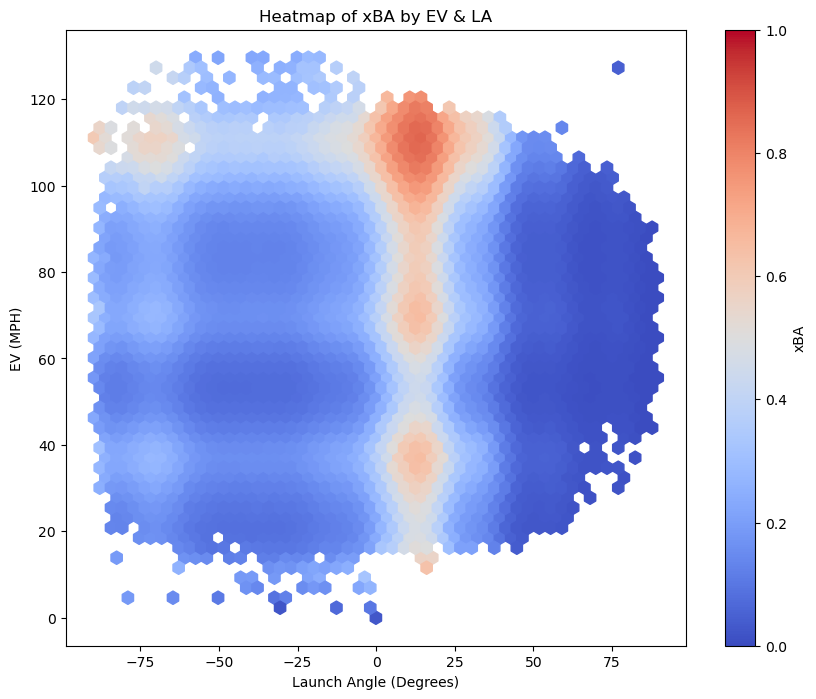

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

hb = plt.hexbin(
    necessary_data['Angle'],
    necessary_data['ExitSpeed'],
    C=necessary_data['xBA'],
    gridsize=50,        # controls resolution
    cmap='coolwarm',
    vmin=0.00,
    vmax=1.00
)

plt.colorbar(hb, label='xBA')
plt.xlabel("Launch Angle (Degrees)")
plt.ylabel("EV (MPH)")
plt.title("Heatmap of xBA by EV & LA")

plt.show()

## Exploring wOBA

We can use publicly available college baseball linear weights as seen here: (https://github.com/nathanblumenfeld/collegebaseball/tree/main/collegebaseball)

In [53]:
## wOBA linear weights

avg_woba = 0.367	
woba_scale = 0.9795	
bb_weight = 0.785404	
hbp_weight = 0.803778	
single_weight = 0.949848	
double_weight = 1.303976	
triple_weight = 1.643932	
hr_weight = 1.977906

## Trusting this is correct for college baseball, can definitely explore more later

In [54]:
necessary_data.sample(15)

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG
101463,"Hopkins, Kole",MOU_OLV,Right,"Diaz, Yariel",BAR_COL,Right,Fastball,Four-Seam,InPlay,Undefined,GroundBall,Single,0,0,85.665580,2337.394851,12:45,6.044940,0.490120,4.941720,21.687020,9.651740,2.158730,-0.411520,97.283840,6.730089,-11.903456,103.629090,-13.929524,0.806064,ca050180-1d45-11f0-8315-f161454222d9,1,1,0.632000,0.698000
148224,"Crystal, Jacob",MOY_MOY,Left,"Randolph, Jake",PRE_BLH,Right,Undefined,Changeup,InPlay,Undefined,FlyBall,Out,1,0,86.361730,2234.490614,10:00,5.789080,-2.200370,4.894160,15.359770,-21.102450,2.735240,-0.366360,96.983890,25.841910,2.598637,356.879970,12.937730,4.921751,1f6f5740-f20a-11ef-8de1-97589797826d,0,0,0.418000,1.242000
564474,"Berggren, Austin",MIA_RED,Right,"Carr, Harry",BUT_BUL,Left,ChangeUp,Slider,InPlay,Undefined,GroundBall,Single,0,0,84.618550,2144.733052,12:45,5.640820,1.871340,5.568680,5.024880,1.923620,1.484140,-0.855950,54.923930,-33.464135,66.845459,4.657940,40.383360,0.036105,33bab1d0-0a75-11f0-b06e-2ffbb3e9d59a,1,1,0.075000,0.052000
506083,"Wilson, Gavin",MOU_OLV,Right,"Chrismon, Nathan",CAT_IND,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,81.002240,2160.954349,9:30,5.667450,2.644990,4.989580,3.104450,-7.605480,1.557290,-0.210750,84.206300,45.101789,-36.088937,NaN,NaN,NaN,6dcbaa00-ee46-11ef-aa06-039fe9c5ff1e,0,0,0.054000,0.039000
220441,"Villareal, Juan",FLO_PAN,Left,"Trommer, Michael",BUC_BIS,Left,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,73.308430,2168.515833,4:15,5.911500,-1.659560,5.590440,-10.653120,17.174970,1.998000,0.974890,76.173450,37.546080,-13.452527,275.597990,-26.120231,4.451283,cb6fe3b0-028c-11f0-a90c-fd91bece62bc,0,0,0.181000,0.423000
54321,"Murry, Grayson",BAY_BEA,Right,"Smith, Derek",UTA_UTE,Right,Slider,Curveball,InPlay,Undefined,GroundBall,FieldersChoice,1,0,76.460180,2236.461631,9:45,4.665200,1.432350,5.251350,4.869220,-7.675870,2.793270,-0.810560,70.162270,-8.458149,-3.693196,17.954810,-0.271031,0.160955,bf371b80-1d59-11f0-8f1a-7152a0e3b3a7,0,0,0.239000,0.086000
1036738,"Green, Zach",NOR_GEO3,Left,"Sharp, Josh",USC_PAC,Left,Fastball,Four-Seam,InPlay,Undefined,LineDrive,Out,1,0,86.314000,2076.948026,10:45,5.537040,-2.562820,6.575940,17.942290,-12.031460,2.831070,-0.113490,87.391580,17.776731,5.031257,286.448040,-2.060707,3.046278,a75ee950-1d5b-11f0-a050-fd6d69c65426,0,0,0.548000,0.661000
676726,"Wilson, Bradley",APP_MOU,Right,"Torres, Cooper",ETS_BUC,Right,Slider,Curveball,InPlay,Undefined,GroundBall,Out,2,0,82.387950,2427.773709,8:00,5.912140,1.221830,5.253320,-7.482210,-16.194650,2.554070,-1.015850,75.241290,-43.836219,1.763382,4.029470,15.969382,0.032981,b644fe60-f3c0-11ef-b22e-b37c3623ac65,0,0,0.142000,0.139000
446943,"Umlandt, Ian",ORE_DUC,Left,"Eckelman, Mason",OSU_BUC,Left,Fastball,Four-Seam,InPlay,Undefined,GroundBall,Single,0,0,85.501510,2055.777505,11:00,6.084320,-1.442590,5.719890,17.597210,-10.313820,1.967680,-0.836480,61.993780,-1.933935,2.497713,21.817550,4.303894,0.225841,5a82c6a0-0cd6-11f0-8dac-fbeb072819c8,1,1,0.237000,0.079000
947015,"Gunter, Justin",LON_LAN,Right,"Morgan, Aaron",GAR_RUN,Right,Fastball,Four-Seam,StrikeSwinging,Strikeout,Undefined,Undefined,1,0,88.377040,1961.352843,1:00,5.567510,0.890730,6.358640,17.465320,9.735910,2.785000,-0.631580,0.000000,0.000000,NaN,NaN,NaN,NaN,93eee630-0d99-11f0-b021-f1f2afa1545d,0,0,0.026000,0.032000


In [75]:
woba_data = master_trackman[['Pitcher', 'PitcherTeam','PitcherThrows', 'Batter', 'BatterTeam', 'BatterSide', 'TaggedPitchType', 'AutoPitchType', 'PitchCall', 'KorBB', 'TaggedHitType', 'PlayResult', 'OutsOnPlay', 'RunsScored', 'RelSpeed', 'SpinRate', 'Tilt', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'ExitSpeed', 'Angle', 'Direction', 'Distance', 'Bearing', 'HangTime', 'PitchUID']]
woba_data = woba_data.dropna(subset = ['PitchCall', 'PlayResult'])
woba_data

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID
0,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028060,2497.731876,12:30,5.621390,0.510940,5.836200,18.231070,4.190400,1.212030,-0.291350,NaN,NaN,NaN,NaN,NaN,NaN,18b54860-14e7-11f0-938f-b5417cf72451
1,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.167840,2782.722426,11:15,5.533740,0.741550,4.993150,6.645160,-2.487760,4.117590,0.142400,NaN,NaN,NaN,NaN,NaN,NaN,205779d0-14e7-11f0-938f-b5417cf72451
2,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,89.170310,2457.952019,12:30,5.673900,0.637670,6.021180,20.687960,4.343740,2.428360,-1.368630,NaN,NaN,NaN,NaN,NaN,NaN,298b6ed0-14e7-11f0-938f-b5417cf72451
3,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.468310,2434.164084,12:30,5.668940,0.529090,5.920580,20.049890,3.916180,3.726920,-0.706240,NaN,NaN,NaN,NaN,NaN,NaN,3189ca00-14e7-11f0-938f-b5417cf72451
4,"Gilbert, Bradley",WAS_HUS,Right,"Peterson, Tyler",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,88.799670,2487.422652,12:45,5.699690,0.707000,5.903890,15.885320,5.797090,3.729990,-1.122990,NaN,NaN,NaN,NaN,NaN,NaN,445b4b40-14e7-11f0-938f-b5417cf72451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326000,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,StrikeCalled,Undefined,Undefined,Undefined,0,0,85.578950,2309.550718,11:00,5.343220,2.092230,6.157400,4.977010,-1.972250,2.480910,-0.516160,NaN,NaN,NaN,NaN,NaN,NaN,5bdd03d0-11d6-11f0-b75a-15defc8841bc
1326001,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,FoulBallNotFieldable,Undefined,Undefined,Undefined,0,0,87.422390,2299.056403,10:45,5.260250,2.269660,6.038550,6.124730,-3.600440,1.818140,0.106260,46.703320,50.600354,120.524254,116.274000,126.704006,3.081668,6451ee90-11d6-11f0-b75a-15defc8841bc
1326002,"Hicks, Garrett",ARI_WIL,Right,"Walker, Kyle",ARI_SUN,Right,Cutter,Slider,InPlay,Undefined,Popup,Out,1,0,87.589110,2338.856413,10:30,5.275490,2.220830,6.206060,4.687760,-3.380080,2.490030,-0.199540,68.609820,40.223331,-3.564189,197.333360,8.108297,4.536495,6f267430-11d6-11f0-b75a-15defc8841bc
1326003,"Hicks, Garrett",ARI_WIL,Right,"Hairston, Landon",ARI_SUN,Left,Cutter,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,85.486640,2312.444806,10:45,5.265290,2.252450,6.183890,7.524530,-4.503700,1.809560,-1.219740,NaN,NaN,NaN,NaN,NaN,NaN,82a5c1a0-11d6-11f0-b75a-15defc8841bc


In [76]:
woba_data['PitchCall'].unique()

array(['BallCalled', 'StrikeCalled', 'InPlay', 'StrikeSwinging',
       'FoulBallNotFieldable', 'BallinDirt', 'HitByPitch',
       'FoulBallFieldable', 'BallIntentional', 'Undefined',
       'AutomaticBall', 'Ballintentional', 'Strikecalled', 'FoulBall',
       'BallInDirt', 'AutomaticStrike', 'BallIInDirt'], dtype=object)

In [77]:
woba_data = woba_data[
    (woba_data['PitchCall'].isin(['InPlay', 'HitByPitch'])) | 
    (woba_data['KorBB'].isin(['Strikeout', 'Walk']))
]

woba_data.head()

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID
3,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.468310,2434.164084,12:30,5.668940,0.529090,5.920580,20.049890,3.916180,3.726920,-0.706240,NaN,NaN,NaN,NaN,NaN,NaN,3189ca00-14e7-11f0-938f-b5417cf72451
8,"Gilbert, Bradley",WAS_HUS,Right,"Peterson, Tyler",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.176990,2481.172792,12:30,5.647470,0.672960,5.867700,15.070720,2.981030,3.871040,0.397090,NaN,NaN,NaN,NaN,NaN,NaN,8c5be940-14e7-11f0-938f-b5417cf72451
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451


In [78]:
woba_data['BB'] = (woba_data['KorBB'] == 'Walk').astype(int)
woba_data['HBP'] = (woba_data['PitchCall'] == 'Hit By Pitch').astype(int)
woba_data['Single'] = (woba_data['PlayResult'].isin(['Single', 'SIngle'])).astype(int)
woba_data['Double'] = (woba_data['PlayResult'] == 'Double').astype(int)
woba_data['Triple'] = (woba_data['PlayResult'].isin(['Triple', 'triple'])).astype(int)
woba_data['HomeRun'] = (woba_data['PlayResult'].isin(['Home Run', 'Homerun', 'HomeRun'])).astype(int)

woba_ucsd = woba_data[(woba_data['BatterTeam'] == 'CSD_TRI')]
woba_ucsd

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/1384475759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  woba_data['BB'] = (woba_data['KorBB'] == 'Walk').astype(int)
/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/1384475759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  woba_data['HBP'] = (woba_data['PitchCall'] == 'Hit By Pitch').astype(int)
/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/1384475759.py:3: SettingWithCopyWarning: 
A value is try

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,BB,HBP,Single,Double,Triple,HomeRun
8102,"Rudd, Andrew",CAL_LAN,Right,"Potestio, Anthony",CSD_TRI,Left,ChangeUp,Changeup,InPlay,Undefined,GroundBall,Single,0,0,81.405610,1703.263930,1:30,6.098290,2.334110,6.322190,15.512130,14.993950,1.493270,0.488210,95.942920,8.876809,20.931431,125.675060,23.805471,1.027225,5da2a3b0-f18c-11ef-9456-e7fd19fa9ca5,0,0,1,0,0,0
8109,"Rudd, Andrew",CAL_LAN,Right,"Lazuka, Noah",CSD_TRI,Right,Fastball,Four-Seam,InPlay,Undefined,LineDrive,Single,0,0,86.983280,2055.587425,12:45,6.080890,1.951060,6.489350,14.887060,5.484020,2.209730,-0.747300,103.880950,1.100340,21.504723,81.960300,23.668520,0.578172,bfdd1fb0-f18c-11ef-9456-e7fd19fa9ca5,0,0,1,0,0,0
8114,"Rudd, Andrew",CAL_LAN,Right,"Leopard, Alex",CSD_TRI,Left,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,75.282080,2131.509495,6:15,6.254680,2.037010,5.340810,-9.753900,-1.371970,1.927620,-0.404780,99.586430,47.082161,28.532669,274.406300,35.006366,6.519484,06853290-f18d-11ef-9456-e7fd19fa9ca5,0,0,0,0,0,0
8115,"Rudd, Andrew",CAL_LAN,Right,"Crossland, Michael",CSD_TRI,Right,Fastball,Four-Seam,InPlay,Undefined,LineDrive,Double,0,2,87.452080,2057.553303,1:00,6.154180,2.077860,6.341940,14.538240,8.095830,3.162810,-0.212580,100.229150,21.534737,11.245996,346.432610,24.851012,4.366282,21a7e9f0-f18d-11ef-9456-e7fd19fa9ca5,0,0,0,1,0,0
8119,"Rudd, Andrew",CAL_LAN,Right,"Camacho, Gabe",CSD_TRI,Left,Slider,Curveball,InPlay,Undefined,Popup,Out,1,0,76.116500,2172.749930,7:15,6.264020,2.134900,5.290020,-3.708980,-3.823310,2.160380,0.293000,80.954380,66.735694,39.722696,NaN,NaN,NaN,5ad7f580-f18d-11ef-9456-e7fd19fa9ca5,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275012,"Rodgers, Peyton",SAN_AZT,Right,"Allen, J.C.",CSD_TRI,Right,Fastball,Sinker,InPlay,Undefined,GroundBall,Out,1,0,89.386940,2106.646605,2:15,5.345820,2.467690,4.789630,10.743190,20.101740,1.794910,-0.329040,102.268340,-11.487379,-8.089295,10.931780,-4.895118,0.062016,e6af6f20-ee86-11ef-8e70-eff9880e989d,0,0,0,0,0,0
1275033,"Rodgers, Peyton",SAN_AZT,Right,"Martinez, Trevian",CSD_TRI,Right,Fastball,Sinker,InPlay,Undefined,GroundBall,Out,1,0,88.393210,2109.354944,1:45,5.504120,2.237700,4.951470,16.444650,19.895560,2.400950,-0.901460,100.672990,-16.393678,20.401502,8.177210,25.700394,0.053845,9e59c160-ee88-11ef-8e70-eff9880e989d,0,0,0,0,0,0
1275035,"Rodgers, Peyton",SAN_AZT,Right,"Hackworth, Patrick",CSD_TRI,Left,Fastball,Sinker,InPlay,Undefined,Popup,Error,0,0,89.180920,2091.785197,1:30,5.443520,2.226300,4.695140,21.048710,19.103320,3.205110,0.004070,87.333590,74.630060,7.081042,NaN,NaN,NaN,bf18ef20-ee88-11ef-8e70-eff9880e989d,0,0,0,0,0,0
1275040,"Rodgers, Peyton",SAN_AZT,Right,"Thacker, Cooper",CSD_TRI,Right,Slider,Slider,StrikeSwinging,Strikeout,Undefined,Undefined,1,0,80.814720,2888.715974,8:15,5.169530,2.493400,4.721330,-2.857400,-8.696890,1.318890,-1.257530,NaN,NaN,NaN,NaN,NaN,NaN,0f1d6690-ee89-11ef-8e70-eff9880e989d,0,0,0,0,0,0


In [79]:
pitch_count = woba_ucsd.groupby(['Batter', 'PitcherThrows']).size().reset_index(name='PAs')
pitch_count.head()

,Batter,PitcherThrows,PAs
0,"Allen, J.C.",Left,40
1,"Allen, J.C.",Right,103
2,"Ambriz, Andy",Left,1
3,"Ambriz, Andy",Right,1
4,"Areliz, Julian",Right,1


In [80]:
## woba function

def calculate_woba(group):
    
    woba = ((bb_weight * group['BB'].sum()) + (hbp_weight * group['HBP'].sum()) + (single_weight * group['Single'].sum()) + (double_weight * group['Double'].sum()) + (triple_weight * group['Triple'].sum()) + (hr_weight * group['HomeRun'].sum())) / group['PitchUID'].count()

    return round(woba, 3)

In [81]:
woba_ucsd = woba_ucsd.groupby(['Batter', 'PitcherThrows']).apply(calculate_woba).reset_index(name = 'wOBA')
woba_ucsd = woba_ucsd.merge(pitch_count, on = ['Batter', 'PitcherThrows'], how = 'left')
woba_ucsd.sort_values(by = ['wOBA', 'PAs'], ascending = False)

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/3061020108.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  woba_ucsd = woba_ucsd.groupby(['Batter', 'PitcherThrows']).apply(calculate_woba).reset_index(name = 'wOBA')


,Batter,PitcherThrows,wOBA,PAs
29,"Patterson, Garrett",Right,0.785000,2
19,"Lee, Jayden",Left,0.785000,1
24,"Lomanto, Colton",Right,0.501000,52
25,"Maher, Thomas",Left,0.447000,15
23,"Lomanto, Colton",Left,0.436000,24
7,"Crossland, Michael",Left,0.429000,46
22,"Leopard, Alex",Right,0.421000,92
28,"Martinez, Trevian",Right,0.414000,74
31,"Potestio, Anthony",Right,0.407000,80
1,"Allen, J.C.",Right,0.403000,103


## xwOBA using a Random Forest model

The thought process is to use a Random Forest classifier to gather probabilities of a batted ball's expected total bases to gather xwOBAcon and then add BB, K, HBP constants to the wOBA formula, inherently calculating xwOBA.

In [82]:
necessary_data.head()

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0,0,0.127000,0.309000
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1,1,0.453000,0.890000
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0,0,0.277000,0.898000
28,"Liddle, Brady",SEA_RED,Right,"Guerrero, AJ",WAS_HUS,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0,0,0.150000,0.596000
31,"Liddle, Brady",SEA_RED,Right,"Taggart, Casen",WAS_HUS,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0,0,0.238000,0.657000


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss

In [84]:
batted_ball = necessary_data[necessary_data['PitchCall'] == 'InPlay']
batted_ball.head()

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0,0,0.127000,0.309000
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1,1,0.453000,0.890000
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0,0,0.277000,0.898000
28,"Liddle, Brady",SEA_RED,Right,"Guerrero, AJ",WAS_HUS,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0,0,0.150000,0.596000
31,"Liddle, Brady",SEA_RED,Right,"Taggart, Casen",WAS_HUS,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0,0,0.238000,0.657000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7048850574712644
Log Loss: 1.1980543400176704
Brier Score: 0.08300093590031346
ROC AUC (OvR): 0.7951773459633087


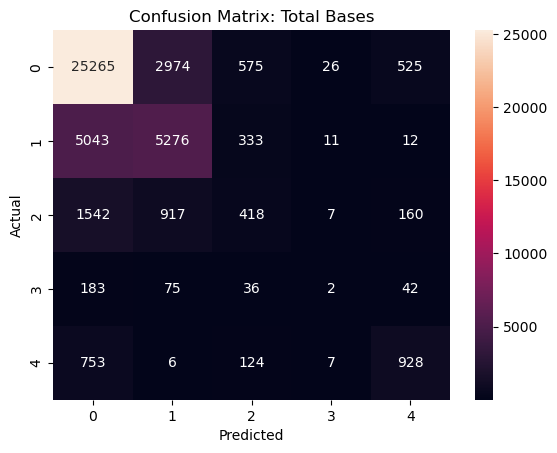

              precision    recall  f1-score   support

           0       0.77      0.86      0.81     29365
           1       0.57      0.49      0.53     10675
           2       0.28      0.14      0.18      3044
           3       0.04      0.01      0.01       338
           4       0.56      0.51      0.53      1818

    accuracy                           0.70     45240
   macro avg       0.44      0.40      0.41     45240
weighted avg       0.68      0.70      0.69     45240



,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG,prob_0,prob_1,prob_2,prob_3,prob_4
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0,0,0.127000,0.309000,0.945000,0.000000,0.000000,0.000000,0.055000
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1,1,0.453000,0.890000,0.010000,0.990000,0.000000,0.000000,0.000000
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0,0,0.277000,0.898000,1.000000,0.000000,0.000000,0.000000,0.000000
28,"Liddle, Brady",SEA_RED,Right,"Guerrero, AJ",WAS_HUS,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0,0,0.150000,0.596000,0.925000,0.000000,0.005000,0.000000,0.070000
31,"Liddle, Brady",SEA_RED,Right,"Taggart, Casen",WAS_HUS,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0,0,0.238000,0.657000,0.915000,0.000000,0.000000,0.020000,0.065000


In [85]:
## Random Forest Model
## Set feature dataset with EV and LA
## Target variable is total bases

X = batted_ball[['ExitSpeed', 'Angle']]
y = batted_ball[['Bases']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

forest_clf = RandomForestClassifier(
    n_estimators = 200,
    max_depth = None, 
    random_state = 42
)

forest_clf.fit(X_train, y_train)

## import evaluation metrics from sklearn
from sklearn.metrics import (
    accuracy_score, log_loss, confusion_matrix, classification_report,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred = forest_clf.predict(X_test)
y_pred_proba = forest_clf.predict_proba(X_test)

# 1. Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# 2. Log Loss
print("Log Loss:", log_loss(y_test, y_pred_proba))

# 3. Brier Score (multi-class)
y_test_bin = label_binarize(y_test, classes=forest_clf.classes_)
brier = ((y_pred_proba - y_test_bin) ** 2).mean()
print("Brier Score:", brier)

# 4. ROC AUC (OvR)
auc_ovr = roc_auc_score(y_test_bin, y_pred_proba, multi_class="ovr")
print("ROC AUC (OvR):", auc_ovr)

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=forest_clf.classes_)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=forest_clf.classes_, yticklabels=forest_clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Total Bases")
plt.show()

# 6. Classification report (per-class precision, recall, F1)
print(classification_report(y_test, y_pred))


## set total base predicted probabilities to a dataset
probs = forest_clf.predict_proba(X)

probs_df = pd.DataFrame(
    probs,
    columns=[f"prob_{cls}" for cls in forest_clf.classes_],
    index=X.index  # keep same index for alignment
)

df_with_probs = necessary_data.join(probs_df)

df_with_probs.head()

In [91]:
df_with_probs['xwOBAcon'] = ((single_weight * df_with_probs['prob_1']) + (double_weight * df_with_probs['prob_2']) + (triple_weight * df_with_probs['prob_3']) + (hr_weight * df_with_probs['prob_4']))
df_with_probs.head()

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG,prob_0,prob_1,prob_2,prob_3,prob_4,xwOBAcon
10,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0,0,0.127000,0.309000,0.945000,0.000000,0.000000,0.000000,0.055000,0.108785
17,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1,1,0.453000,0.890000,0.010000,0.990000,0.000000,0.000000,0.000000,0.940350
23,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0,0,0.277000,0.898000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28,"Liddle, Brady",SEA_RED,Right,"Guerrero, AJ",WAS_HUS,Right,Fastball,Changeup,InPlay,Undefined,FlyBall,Out,1,0,84.307650,1944.662595,12:45,6.154940,1.219310,5.666210,24.218560,10.365790,2.282820,0.281030,98.371150,42.141418,6.087939,294.432960,12.932060,6.089601,654dac10-14e9-11f0-938f-b5417cf72451,0,0,0.150000,0.596000,0.925000,0.000000,0.005000,0.000000,0.070000,0.144973
31,"Liddle, Brady",SEA_RED,Right,"Taggart, Casen",WAS_HUS,Left,Slider,Curveball,InPlay,Undefined,FlyBall,Out,1,0,77.071870,1946.982870,2:30,5.567770,1.701330,5.636120,3.134690,4.950160,1.974010,0.526970,93.321310,35.717052,-15.554277,296.789660,-34.844112,4.892005,8f7a2e50-14e9-11f0-938f-b5417cf72451,0,0,0.238000,0.657000,0.915000,0.000000,0.000000,0.020000,0.065000,0.161443


In [92]:
xwobacon_df = necessary_data.merge(df_with_probs, on = list(necessary_data.columns), how = 'left')
xwobacon_df.shape[0]

293370

In [93]:
master_trackman['PitchCall'].unique()

array(['BallCalled', 'StrikeCalled', 'InPlay', 'StrikeSwinging',
       'FoulBallNotFieldable', 'BallinDirt', 'HitByPitch',
       'FoulBallFieldable', 'BallIntentional', 'Undefined',
       'AutomaticBall', 'Ballintentional', 'Strikecalled', 'FoulBall',
       'BallInDirt', 'AutomaticStrike', 'BallIInDirt'], dtype=object)

In [94]:
## reset master trackman to include balls in play, walks, HBPs, and Ks

valid_outcomes = master_trackman[
    (master_trackman['KorBB'].isin(['Strikeout', 'Walk']) & master_trackman['PitchCall'].isin(['BallCalled', 'StrikeCalled', 'StrikeSwinging', 'HitByPitch', 'Strikecalled', 'BallInDirt', 'BallIInDirt'])) |
    (master_trackman['PitchCall'].isin(['InPlay']))
][['Pitcher', 'PitcherTeam','PitcherThrows', 'Batter', 'BatterTeam', 'BatterSide', 'TaggedPitchType', 'AutoPitchType', 'PitchCall', 'KorBB', 'TaggedHitType', 'PlayResult', 'OutsOnPlay', 'RunsScored', 'RelSpeed', 'SpinRate', 'Tilt', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'ExitSpeed', 'Angle', 'Direction', 'Distance', 'Bearing', 'HangTime', 'PitchUID']]

valid_outcomes.shape[0]

331455

In [95]:
## merge on the xwobacon total base probabilities dataset from the random forest model

xwobacon = valid_outcomes.merge(df_with_probs, on = list(valid_outcomes.columns), how = 'left')
xwobacon = xwobacon.fillna(0)
xwobacon.head()

,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG,prob_0,prob_1,prob_2,prob_3,prob_4,xwOBAcon
0,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.468310,2434.164084,12:30,5.668940,0.529090,5.920580,20.049890,3.916180,3.726920,-0.706240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3189ca00-14e7-11f0-938f-b5417cf72451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Gilbert, Bradley",WAS_HUS,Right,"Peterson, Tyler",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.176990,2481.172792,12:30,5.647470,0.672960,5.867700,15.070720,2.981030,3.871040,0.397090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8c5be940-14e7-11f0-938f-b5417cf72451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0.000000,0.000000,0.127000,0.309000,0.945000,0.000000,0.000000,0.000000,0.055000,0.108785
3,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1.000000,1.000000,0.453000,0.890000,0.010000,0.990000,0.000000,0.000000,0.000000,0.940350
4,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0.000000,0.000000,0.277000,0.898000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [96]:
## encode walks and HBPs again

xwobacon['Walk'] = (xwobacon['KorBB'] == 'Walk').astype(int)
xwobacon['HitByPitch'] = (xwobacon['KorBB'] == 'HitByPitch').astype(int)
xwobacon.head()


,Pitcher,PitcherTeam,PitcherThrows,Batter,BatterTeam,BatterSide,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,SpinRate,Tilt,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ExitSpeed,Angle,Direction,Distance,Bearing,HangTime,PitchUID,Hit,Bases,xBA,xSLG,prob_0,prob_1,prob_2,prob_3,prob_4,xwOBAcon,Walk,HitByPitch
0,"Gilbert, Bradley",WAS_HUS,Right,"Ishikawa, Keni",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.468310,2434.164084,12:30,5.668940,0.529090,5.920580,20.049890,3.916180,3.726920,-0.706240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3189ca00-14e7-11f0-938f-b5417cf72451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
1,"Gilbert, Bradley",WAS_HUS,Right,"Peterson, Tyler",SEA_RED,Left,Fastball,Four-Seam,BallCalled,Walk,Undefined,Undefined,0,0,89.176990,2481.172792,12:30,5.647470,0.672960,5.867700,15.070720,2.981030,3.871040,0.397090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8c5be940-14e7-11f0-938f-b5417cf72451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
2,"Gilbert, Bradley",WAS_HUS,Right,"Kane, Sam",SEA_RED,Right,Slider,Slider,InPlay,Undefined,FlyBall,Out,1,0,82.470560,2725.977171,9:30,5.546190,0.733100,5.050820,2.953940,-4.669880,1.773770,-0.071790,90.936520,40.323030,-5.968970,276.412990,-4.938970,5.767655,ac9ce650-14e7-11f0-938f-b5417cf72451,0.000000,0.000000,0.127000,0.309000,0.945000,0.000000,0.000000,0.000000,0.055000,0.108785,0,0
3,"Gilbert, Bradley",WAS_HUS,Right,"Harmon, Reese",SEA_RED,Left,Fastball,Changeup,InPlay,Undefined,LineDrive,Single,0,1,86.708720,1876.123399,2:30,5.507600,0.900390,5.883020,7.790750,21.118200,2.254870,1.476370,69.382380,22.578153,-8.859449,213.886670,-17.805961,3.209279,24846530-14e8-11f0-938f-b5417cf72451,1.000000,1.000000,0.453000,0.890000,0.010000,0.990000,0.000000,0.000000,0.000000,0.940350,0,0
4,"Gilbert, Bradley",WAS_HUS,Right,"Wagoner, Jake",SEA_RED,Right,Curveball,Curveball,InPlay,Undefined,FlyBall,Out,1,0,76.199630,2729.589040,6:15,5.750160,0.282370,5.025860,-16.695280,-3.334730,2.569330,-0.382080,88.926370,27.951601,0.699696,305.086550,6.021101,4.774202,aaa4a350-14e8-11f0-938f-b5417cf72451,0.000000,0.000000,0.277000,0.898000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0


In [97]:
# calculate xwoba using walk, hbp weights + xwobacon per PA
def calculate_xwoba(group):
    
    xwoba = ((bb_weight * group['Walk'].sum()) + (hbp_weight * group['HitByPitch'].sum()) + (group['xwOBAcon'].sum())) / group['PitchUID'].count()

    return round(xwoba, 3)

In [98]:
xwoba_ucsd = xwobacon[xwobacon['BatterTeam'] == 'CSD_TRI'].groupby(['Batter', 'PitcherThrows']).apply(calculate_xwoba).reset_index(name = 'xwOBA')
xwoba_ucsd = xwoba_ucsd.merge(woba_ucsd, on = ['Batter', 'PitcherThrows'], how = 'left')
xwoba_ucsd['xwOBA_diff'] = xwoba_ucsd['wOBA'] - xwoba_ucsd['xwOBA']
xwoba_ucsd

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_29349/2536006131.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xwoba_ucsd = xwobacon[xwobacon['BatterTeam'] == 'CSD_TRI'].groupby(['Batter', 'PitcherThrows']).apply(calculate_xwoba).reset_index(name = 'xwOBA')


,Batter,PitcherThrows,xwOBA,wOBA,PAs,xwOBA_diff
0,"Allen, J.C.",Left,0.385000,0.314000,40,-0.071000
1,"Allen, J.C.",Right,0.395000,0.403000,103,0.008000
2,"Ambriz, Andy",Left,0.000000,0.000000,1,0.000000
3,"Ambriz, Andy",Right,0.000000,0.000000,1,0.000000
4,"Camacho, Gabe",Left,0.287000,0.223000,37,-0.064000
5,"Camacho, Gabe",Right,0.398000,0.366000,92,-0.032000
6,"Crossland, Michael",Left,0.415000,0.429000,46,0.014000
7,"Crossland, Michael",Right,0.427000,0.397000,115,-0.030000
8,"Davidson, Garrett",Left,0.019000,0.000000,2,-0.019000
9,"Davidson, Garrett",Right,0.233000,0.209000,20,-0.024000
